# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv('api.env')

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [5]:
# Fetch current BTC price
btc_price = requests.get(btc_url).json()
# Fetch current ETH price
eth_price = requests.get(eth_url).json()

# Compute current value of my crpto
my_btc_value = btc_price['data']['1']['quotes']['USD']['price']
my_eth_value = eth_price['data']['1027']['quotes']['USD']['price']

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $27633.00
The current value of your 5.3 ETH is $1578.57


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [8]:
# Format current date as ISO format
today = pd.Timestamp("2023-10-06", tz="America/New_york").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_tickers = alpaca.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today
).df

df_tickers

# Reorganize the DataFrame
# Separate ticker data
AGG = df_tickers[df_tickers['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_tickers[df_tickers['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
df_tickers = pd.concat([AGG, SPY], axis=1, keys=['AGG', 'SPY'])

# Preview DataFrame
df_tickers

AGG                                              \
                            open   high      low  close   volume trade_count   
timestamp                                                                      
2023-10-06 04:00:00+00:00  92.46  92.98  92.3708  92.75  9569518       29324   

                                         SPY                          \
                                vwap    open     high    low   close   
timestamp                                                              
2023-10-06 04:00:00+00:00  92.731221  421.97  431.125  420.6  429.54   

                                                              
                              volume trade_count        vwap  
timestamp                                                     
2023-10-06 04:00:00+00:00  113273309      737826  426.955955

In [9]:
# Pick AGG and SPY close prices
agg_close_price = df_tickers["AGG"]["close"][0]
spy_close_price = df_tickers["SPY"]["close"][0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $92.75
Current SPY closing price: $429.54


In [10]:
# Compute the current value of shares
my_agg_value = my_agg * agg_close_price
my_spy_value = my_spy * spy_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $21477.00
The current value of your 200 AGG shares is $18550.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto_assets = my_btc_value + my_eth_value
stocks_assets = my_agg_value + my_spy_value
data = {'amount':[crypto_assets, stocks_assets]}

# Create savings DataFrame
df_savings = pd.DataFrame(data, index=['crypto', 'shares'])

# Display savings DataFrame
display(df_savings)

,amount
crypto,29211.57
shares,40027.00


<Axes: title={'center': 'Composition of Personal Savings'}, ylabel='amount'>

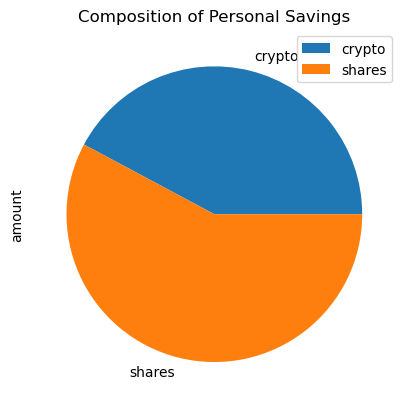

In [12]:
# Plot savings pie chart
df_savings.plot.pie(y="amount", title = "Composition of Personal Savings")

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings['amount'].sum()

# Validate saving health
if total_savings > emergency_fund:
    print(f"Congratulation!You have enough moeny in this fund")
    
elif total_savings == emergency_fund:
    print("Congratulation! You reached the financial goal.")
    
elif total_savings < emergency_fund:
    print("How many dollors away from reaching the goal")

Congratulation!You have enough moeny in this fund


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2018-10-06', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2023-10-06', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start =start_date,
    end = end_date
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = df_stock_data[df_stock_data['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_stock_data[df_stock_data['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG,SPY], axis=1, keys=['AGG', 'SPY'])

# Display sample data
df_stock_data.head()

AGG                                        \
                             open      high       low   close    volume   
timestamp                                                                 
2018-10-08 04:00:00+00:00  104.38  104.4000  104.2900  104.29   2267961   
2018-10-09 04:00:00+00:00  104.39  104.5099  104.3200  104.44  21904070   
2018-10-10 04:00:00+00:00  104.34  104.4600  104.2335  104.41   3835165   
2018-10-11 04:00:00+00:00  104.59  104.8600  104.5100  104.72   7053895   
2018-10-12 04:00:00+00:00  104.71  104.8699  104.6750  104.75   5017438   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2018-10-08 04:00:00+00:00        9340  104.335951  287.05  288.22  285.50   
2018-10-09 04:00:00+00:00       11221  104.444794  287.39  288.86  286.77   
2018-10-10 04:00:00+00:00       15622  104.361196  286.83  286.91  277.88   
2018-10-11 04:00:00+00:00       22868  104.714936  277.08  278.90  270.36   
2018-10-12 04:00:00+00:00       17066  104.765518  276.77  277.09  272.37   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2018-10-08 04:00:00+00:00  287.80   87853812      395330  287.185289  
2018-10-09 04:00:00+00:00  287.48   74389172      334051  287.725041  
2018-10-10 04:00:00+00:00  278.27  215567771      877254  282.024892  
2018-10-11 04:00:00+00:00  272.54  275225580     1469827  275.054273  
2018-10-12 04:00:00+00:00  276.01  186452035      991520  274.919809

In [16]:
#Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
monte_carlo = MCSimulation(
    portfolio_data= df_stock_data,
    weights=[.40, .60],
    num_simulation= 500,
    num_trading_days= 252 * 30)

In [17]:
# Printing the simulation input data 
monte_carlo.portfolio_data.head()

AGG                                        \
                             open      high       low   close    volume   
timestamp                                                                 
2018-10-08 04:00:00+00:00  104.38  104.4000  104.2900  104.29   2267961   
2018-10-09 04:00:00+00:00  104.39  104.5099  104.3200  104.44  21904070   
2018-10-10 04:00:00+00:00  104.34  104.4600  104.2335  104.41   3835165   
2018-10-11 04:00:00+00:00  104.59  104.8600  104.5100  104.72   7053895   
2018-10-12 04:00:00+00:00  104.71  104.8699  104.6750  104.75   5017438   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2018-10-08 04:00:00+00:00        9340  104.335951          NaN  287.05   
2018-10-09 04:00:00+00:00       11221  104.444794     0.001438  287.39   
2018-10-10 04:00:00+00:00       15622  104.361196    -0.000287  286.83   
2018-10-11 04:00:00+00:00       22868  104.714936     0.002969  277.08   
2018-10-12 04:00:00+00:00       17066  104.765518     0.000286  276.77   

                                                                          \
                             high     low   close     volume trade_count   
timestamp                                                                  
2018-10-08 04:00:00+00:00  288.22  285.50  287.80   87853812      395330   
2018-10-09 04:00:00+00:00  288.86  286.77  287.48   74389172      334051   
2018-10-10 04:00:00+00:00  286.91  277.88  278.27  215567771      877254   
2018-10-11 04:00:00+00:00  278.90  270.36  272.54  275225580     1469827   
2018-10-12 04:00:00+00:00  277.09  272.37  276.01  186452035      991520   

                                                    
                                 vwap daily_return  
timestamp                                           
2018-10-08 04:00:00+00:00  287.185289          NaN  
2018-10-09 04:00:00+00:00  287.725041    -0.001112  
2018-10-10 04:00:00+00:00  282.024892    -0.032037  
2018-10-11 04:00:00+00:00  275.054273    -0.020592  
2018-10-12 04:00:00+00:00  274.919809     0.012732

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
monte_carlo.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 110.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 120.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 130.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 140.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 150.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 160.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 170.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 180.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 190.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 200.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 210.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 220.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 230.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 240.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 250.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 260.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 270.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 280.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 290.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 300.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 310.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 320.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 330.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 340.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 350.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 360.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 370.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 380.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 390.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 400.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 410.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 420.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 430.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 440.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 450.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 460.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 470.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 480.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 490.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998822,0.986766,1.012800,1.005170,1.003109,1.008376,1.002549,1.005669,0.990828,1.008295,...,0.998953,1.014029,0.998315,1.005209,0.997471,0.994607,1.001929,0.995522,0.995293,0.995793
2,1.001762,0.980928,1.003019,1.001316,0.999358,1.000333,1.001093,1.008445,0.986005,1.020235,...,0.988270,1.013899,1.003999,1.011836,0.998502,0.994030,0.993544,0.997312,0.999911,1.002973
3,1.009091,0.992247,0.991700,1.002246,1.003123,0.993094,1.002207,1.018703,0.985673,1.028113,...,0.998792,1.009829,1.006540,1.004491,1.015454,1.002353,0.984140,0.989738,0.999612,0.994424
4,1.001261,0.988453,0.985273,1.004869,1.001787,0.991890,0.985125,1.015185,0.993002,1.032902,...,1.000308,1.020036,1.007029,0.993625,1.014212,1.007301,0.972757,0.994294,1.006769,0.993335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,2.947617,0.845999,9.074822,5.657125,2.816459,2.204513,4.433571,10.274274,2.170617,3.151472,...,3.612626,6.327914,7.627405,2.826413,2.355873,6.302326,1.529577,2.802056,4.902023,7.366564
7557,2.919307,0.851476,8.910913,5.677333,2.799892,2.206433,4.441428,10.311915,2.191701,3.093223,...,3.622747,6.281636,7.588474,2.825890,2.365832,6.308568,1.522888,2.790823,4.873499,7.398192
7558,2.897236,0.848898,8.884594,5.596929,2.748875,2.192978,4.438142,10.237043,2.204055,3.082818,...,3.642489,6.283500,7.554924,2.823611,2.373905,6.311074,1.532648,2.787417,4.909558,7.446749
7559,2.928754,0.858074,8.893874,5.539455,2.710076,2.192688,4.440982,10.252227,2.200556,3.147761,...,3.637254,6.217517,7.490027,2.836068,2.330607,6.244402,1.527812,2.811283,4.875037,7.530887


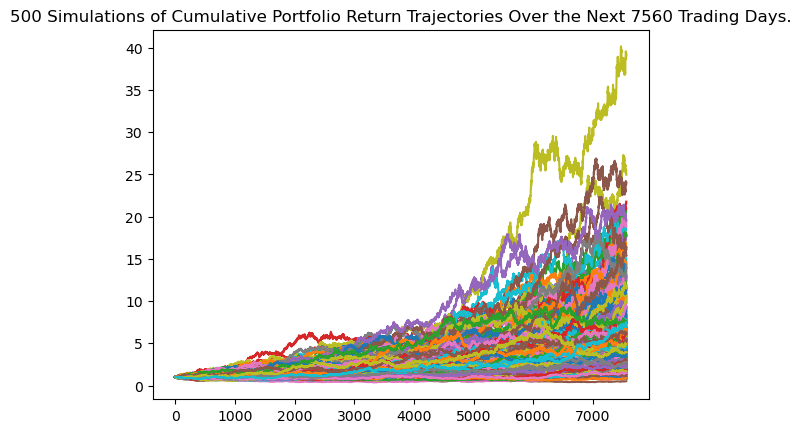

In [19]:
# Plot simulation outcomes
line_plot = monte_carlo.plot_simulation()

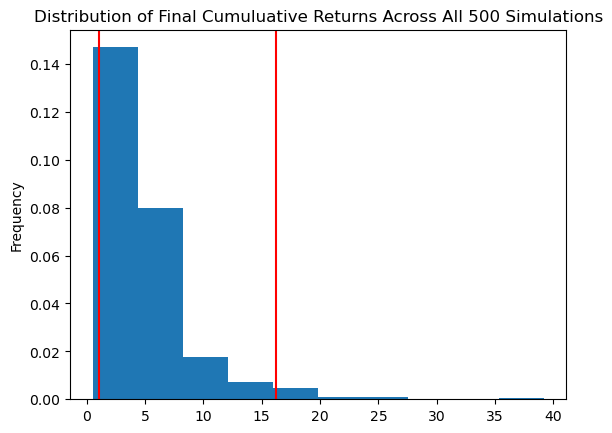

In [20]:
# Plot probability distribution and confidence intervals
dist_plot = monte_carlo.plot_distribution()

### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = monte_carlo.summarize_cumulative_return()

# Print summary statistics
print(tbl)

25%               2.465128
50%               3.919943
75%               5.860489
95% CI Lower      1.048998
95% CI Upper     16.256428
count           500.000000
max              39.175522
mean              4.911279
min               0.515672
std               4.003030
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[3]*20000,2)
ci_upper = round(tbl[4]*20000,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $20979.95 and $325128.56


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[3]*30000,2)
ci_upper = round(tbl[4]*30000,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $31469.93 and $487692.84


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
monte_carlo_5yrs = MCSimulation(
    portfolio_data= df_stock_data,
    weights= [.40,.60],
    num_simulation= 500,
    num_trading_days= 252*5
)

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
monte_carlo_5yrs.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 110.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 120.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 130.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 140.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 150.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 160.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 170.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 180.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 190.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 200.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 210.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 220.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 230.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 240.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 250.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 260.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 270.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 280.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 290.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 300.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 310.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 320.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 330.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 340.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 350.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 360.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 370.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 380.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 390.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 400.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 410.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 420.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 430.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 440.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 450.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 460.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 470.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 480.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 490.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000146,0.988809,1.012202,1.010938,1.008023,0.996381,1.002234,1.007918,0.996336,0.998991,...,0.982926,1.006037,1.016203,0.994662,1.007100,0.993233,0.998409,0.997264,1.005199,0.991287
2,0.995456,0.991837,1.008255,0.999534,1.002592,0.999268,1.006620,0.994116,0.994301,0.994004,...,0.982041,1.007652,1.029035,0.993792,1.003759,0.987040,1.001988,1.013402,1.007562,0.983069
3,1.018244,0.989062,0.996870,1.001524,0.995360,0.994506,1.022035,0.986013,0.979843,0.991169,...,0.979031,1.003641,1.031210,1.004397,1.014811,0.999540,0.998982,1.022225,1.001785,0.982857
4,1.008686,0.999942,1.005113,1.000095,0.995328,1.000619,1.009788,0.986224,0.987275,0.989756,...,0.982853,1.002612,1.024412,1.008228,1.013804,1.003601,0.996455,1.013696,0.991319,0.983304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.925286,0.744776,1.452379,0.982878,1.111312,0.947934,1.232914,1.235366,1.363611,0.796134,...,0.980240,1.483704,1.350593,1.200844,0.860977,0.986664,1.162145,1.302319,1.387335,1.181998
1257,0.925191,0.747694,1.460989,0.985015,1.106380,0.952824,1.245102,1.234245,1.359439,0.794932,...,0.968813,1.488357,1.355167,1.186644,0.851413,1.000425,1.151191,1.300591,1.376011,1.185810
1258,0.910499,0.750892,1.466116,0.984287,1.110526,0.939288,1.243707,1.226123,1.340227,0.800205,...,0.963698,1.493799,1.344292,1.191205,0.840392,1.002320,1.165152,1.290940,1.375354,1.178516
1259,0.922099,0.759336,1.451862,0.990076,1.107565,0.929638,1.243959,1.223861,1.334886,0.790286,...,0.970860,1.506157,1.337467,1.186000,0.848019,0.989992,1.177451,1.288415,1.385878,1.174363


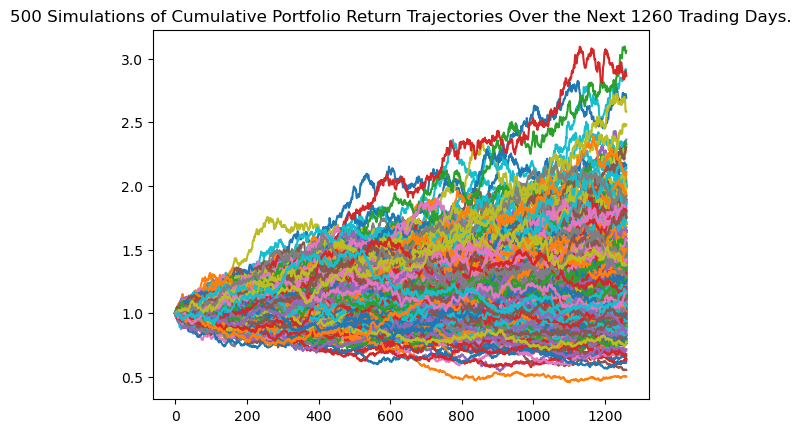

In [26]:
# Plot simulation outcomes
line_plot = monte_carlo_5yrs.plot_simulation()

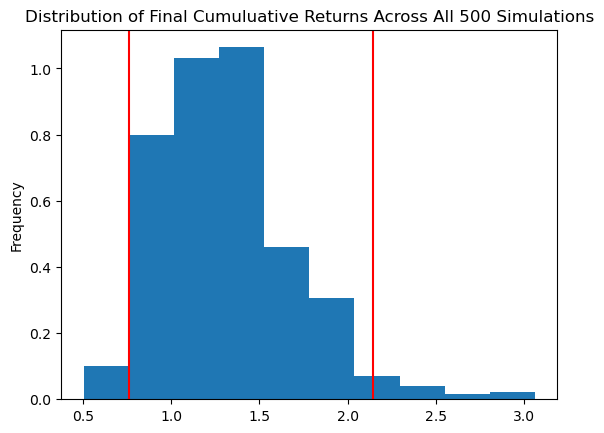

In [27]:
# Plot probability distribution and confidence intervals
dist_plot = monte_carlo_5yrs.plot_distribution()

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_5yrs = monte_carlo_5yrs.summarize_cumulative_return()
# Print summary statistics
print(tbl_5yrs)

25%               1.044815
50%               1.282060
75%               1.510638
95% CI Lower      0.760589
95% CI Upper      2.142749
count           500.000000
max               3.061528
mean              1.318407
min               0.504812
std               0.380555
Name: 1260, dtype: float64


In [29]:
# Set initial investment
inital_investment = 20000 * 3

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(tbl_5yrs[3]*60000,2)
ci_upper_five = round(tbl_5yrs[4]*60000,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 5 years will end within in the range of $45635.32 and $128564.92


### Ten Years Retirement Option

In [30]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
monte_carlo_10yrs = MCSimulation(
    portfolio_data= df_stock_data,
    weights=[.40,.60],
    num_simulation= 500,
    num_trading_days= 252*10
)

In [31]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
monte_carlo_10yrs.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 110.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 120.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 130.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 140.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 150.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 160.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 170.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 180.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 190.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 200.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 210.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 220.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 230.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 240.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 250.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 260.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 270.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 280.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 290.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 300.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 310.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 320.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 330.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 340.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 350.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 360.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 370.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 380.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 390.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 400.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 410.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 420.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 430.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 440.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 450.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 460.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 470.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 480.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 490.


C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\shant\API Assignment\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.989248,0.993921,1.016711,1.001798,1.004185,0.999170,1.001493,0.999363,1.001729,0.997182,...,1.005708,1.000782,0.994206,0.984786,0.998962,0.994090,1.007315,0.995679,0.998385,0.999109
2,0.994201,0.992780,1.017180,1.003746,1.005131,1.006658,0.992214,1.007501,0.993542,0.990513,...,1.014000,1.016868,0.993025,0.974486,1.005742,0.998379,1.013796,0.980840,1.002887,1.001874
3,0.996913,1.002969,1.022581,0.984319,1.002227,0.990973,0.989403,0.986477,1.004982,0.981046,...,1.014036,1.014445,0.988089,0.974992,0.999481,0.997849,1.002114,0.978494,1.003307,1.015396
4,0.996570,1.006934,1.021403,0.999518,1.002950,0.986798,0.987352,0.995703,1.004784,0.980562,...,1.007874,1.009851,0.989917,0.974137,0.986174,0.999859,1.019722,0.978615,1.013588,1.014958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.238648,2.327234,1.035947,0.935284,1.115539,2.009311,1.313296,1.550445,0.843958,0.616748,...,1.300214,2.240153,1.434435,1.348315,2.451397,1.115658,1.292234,1.231270,0.716263,1.574313
2517,1.233616,2.329425,1.030049,0.955283,1.104772,1.989989,1.307779,1.555803,0.844364,0.618814,...,1.297779,2.232615,1.417832,1.337347,2.466715,1.115954,1.284132,1.237369,0.719635,1.574493
2518,1.237976,2.300189,1.042422,0.967750,1.108911,2.010048,1.308184,1.562158,0.852151,0.622665,...,1.294012,2.243373,1.440996,1.326113,2.487873,1.121406,1.277713,1.230148,0.721125,1.566704
2519,1.234771,2.282244,1.040344,0.971965,1.095508,2.002548,1.298913,1.561110,0.859631,0.618738,...,1.291925,2.246402,1.433601,1.306158,2.522341,1.116263,1.278311,1.226617,0.723511,1.562368


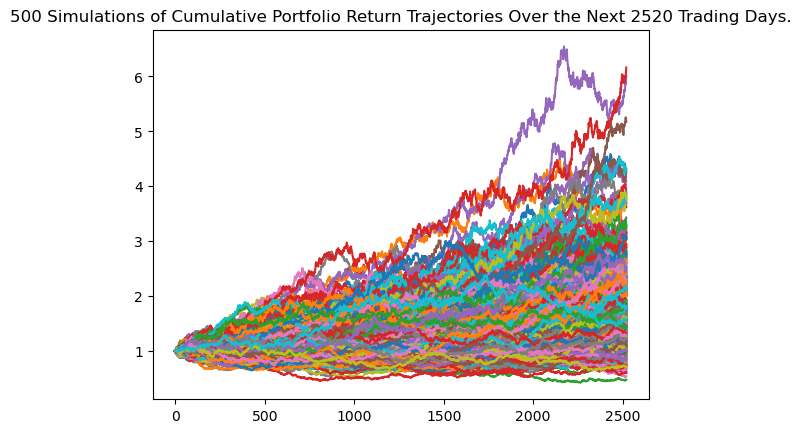

In [32]:
# Plot simulation outcomes
line_plot = monte_carlo_10yrs.plot_simulation()

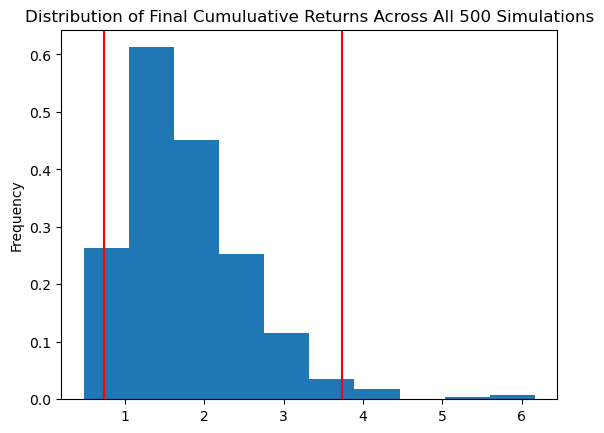

In [33]:
# Plot probability distribution and confidence intervals
dist_plot = monte_carlo_10yrs.plot_distribution()

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_10yrs = monte_carlo_10yrs.summarize_cumulative_return()

# Print summary statistics
print(tbl_10yrs)

25%               1.205093
50%               1.623624
75%               2.160768
95% CI Lower      0.735323
95% CI Upper      3.732898
count           500.000000
max               6.164465
mean              1.770967
min               0.482282
std               0.781561
Name: 2520, dtype: float64


In [36]:
# Set initial investment
initial_investment = 20000 * 3

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(tbl_10yrs[3]*60000,2)
ci_upper_ten = round(tbl_10yrs[4]*60000,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $44119.4 and $223973.89
